In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os, sys
sys.path.append('..')
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
tqdm.monitor_interval = 0

In [26]:
history = glob('../data/raw_hist/*')
print(len(history))

245


In [29]:
route_integrity = []
for hfile in tqdm(history):
# for hfile in history:
    mat = np.load(hfile)
    total = mat.shape[0] * mat.shape[1]
    nMissing = np.count_nonzero(np.isnan(mat))
    integ = (total - nMissing) / total
    
    # interpolate locally or temporally
    nanInds = np.argwhere(np.isnan(mat))
    assert len(nanInds)
#     interp = 0
    tf, sf = mat.shape[0] - 1, mat.shape[1] - 1
    recover = []
    for ti, si in nanInds:
        tint, lint = False, False
        if ti == 0 or ti == tf or si == 0 or si == sf:
            continue
        temp = [mat[ti-1, si], mat[ti+1, si]]
        loc = [mat[ti, si-1], mat[ti, si+1]]
        if np.sum(np.isnan(temp)) == 0:
            tint = True
        if np.sum(np.isnan(loc)) == 0:
            lint = True
        recover.append((ti, si, tint, lint))
    
    dest = mat.copy()
    recover = list(filter(lambda tup: tup[2] or tup[3], recover))
    interp = len(recover)
    for ti, si, tint, lint in recover:
        if tint and lint:
            dest[ti, si] = np.mean(mat[[ti-1, ti+1, ti, ti], [si, si, si+1, si-1]])
        elif tint:
            dest[ti, si] = np.mean(mat[[ti-1, ti+1], [si, si]])
        elif lint:
            dest[ti, si] = np.mean(mat[[ti, ti], [si+1, si-1]])
    
    np.save(hfile.replace('raw_hist', 'history'), dest)
    
    route_integrity.append(
        dict(
            name=fileName(hfile), 
            integ=integ,
            interp=interp/total,
            seglen=mat.shape[1]))
#     break

100%|██████████| 245/245 [20:11<00:00,  4.94s/it]


In [48]:
route_integrity = list(reversed(sorted(route_integrity, key=lambda ent: ent['integ'])))

In [49]:
for route in route_integrity[:50]:
    print(
        route['seglen'], 
        route['name'], 
        '%.1f%%' % (route['integ'] * 100), 
        '%.1f%%' % (route['interp'] * 100))

14 M86-SBS_0 74.6% 10.5%
53 M103_0 71.5% 12.0%
62 M7_0 69.4% 11.9%
55 Q30_0 56.0% 12.4%
63 Q24_0 52.7% 15.3%
61 M11_0 51.4% 12.9%
40 X10B_0 33.8% 7.0%


In [56]:
from utils import *

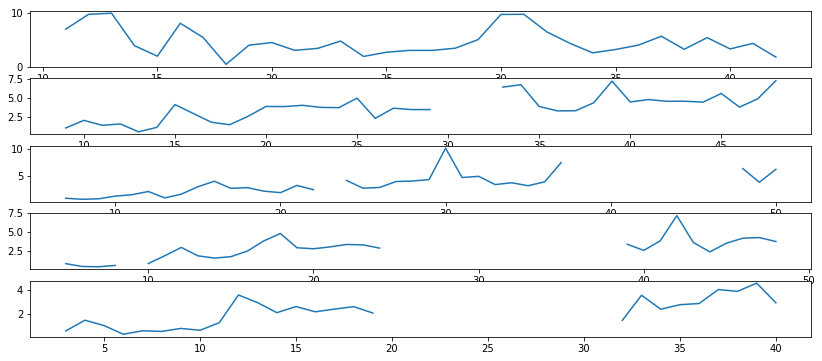

In [58]:
show_travels(history_byname('M103_0', root='raw_hist', ext='csv.npy'), recent=5)

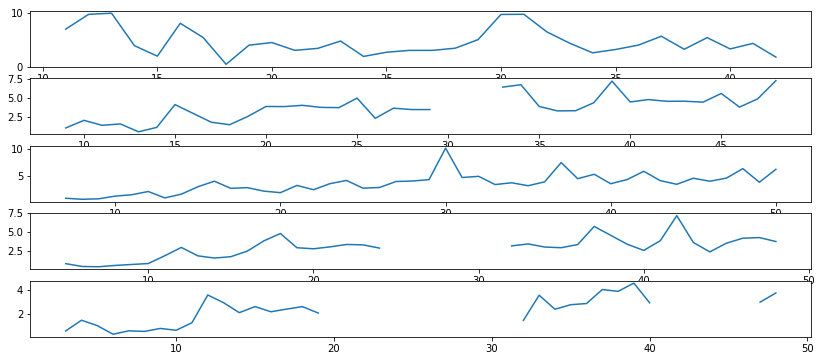

In [59]:
show_travels(history_byname('M103_0'), recent=5)